In [89]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('https://www.ishelp.info/data/insurance.csv')

# Generate dummy variables
for col in df:  
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], prefix=col, dtype=int)
    
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [90]:
y = df['bmi']
X = df.drop(columns=['bmi', 'sex_female', 'region_northwest', 'region_northeast', 'smoker_yes', 'children']).assign(const=1)

# Run the multiple linear regression model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())  # View results

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     49.54
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           4.10e-55
Time:                        19:54:02   Log-Likelihood:                -4182.3
No. Observations:                1338   AIC:                             8379.
Df Residuals:                    1331   BIC:                             8415.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.0284      0.013  

In [91]:
df['ln_charges'] = np.log(df['charges'])

y = df['bmi']  # Transformed variable
X = df.drop(columns=['bmi', 'charges', 'ln_charges', 'sex_female', 'region_northwest', 'region_northeast', 'smoker_yes', 'children']).assign(const=1)

# Run the multiple linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     28.36
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.19e-27
Time:                        19:54:02   Log-Likelihood:                -4249.5
No. Observations:                1338   AIC:                             8511.
Df Residuals:                    1332   BIC:                             8542.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0488      0.011  

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Feature        VIF
0               age   1.001120
1          sex_male   1.006351
2         smoker_no   1.011157
3  region_southeast   1.140487
4  region_southwest   1.136512
5             const  15.076519


In [93]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Create a blank DataFrame to store the results
df_vif = pd.DataFrame(columns=['VIF', 'Tolerance'])
df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, drop_first=True)

df = df.astype(float)

for col in df.drop(columns=['ln_charges']):
    y = df[col]
    X = df.drop(columns=[col, 'ln_charges']).assign(const=1)
    
    r_squared = sm.OLS(y, X).fit().rsquared

    if r_squared < 1:  # Prevent division by zero runtime error
        df_vif.loc[col] = [1 / (1 - r_squared), 1 - r_squared]
    else:
        df_vif.loc[col] = [np.inf, 1 - r_squared]  # Use np.inf instead of a string

# Sort VIF values in descending order
df_vif.sort_values(by=['VIF'], ascending=False, inplace=True)

print(df_vif)


                       VIF  Tolerance
smoker_yes             inf   0.000000
smoker_no              inf   0.000000
sex_male               inf   0.000000
sex_female             inf   0.000000
region_northeast       inf   0.000000
region_northwest       inf   0.000000
region_southeast       inf   0.000000
region_southwest       inf   0.000000
charges           4.014662   0.249087
age               1.373348   0.728148
bmi               1.223757   0.817156
children          1.013005   0.987162


In [94]:
model = sm.OLS(df['ln_charges'], X).fit()
df_insample = pd.DataFrame({
    'Actual': df['ln_charges'], 
    'Predicted': model.fittedvalues, 
    'Residuals (Error)': df['ln_charges'] - model.fittedvalues
})

# Display the first 10 rows
df_insample.head(10)


,Actual,Predicted,Residuals (Error)
0,9.734176,9.036831,0.697346
1,7.453302,7.881871,-0.428569
2,8.400538,8.392544,0.007994
3,9.998092,9.310288,0.687804
4,8.260197,8.292025,-0.031829
5,8.231275,8.291626,-0.060351
6,9.016827,8.883953,0.132874
7,8.893093,8.881928,0.011165
8,8.765054,8.725321,0.039733
9,10.272397,10.297692,-0.025295


np.float64(0.8150574830225468)

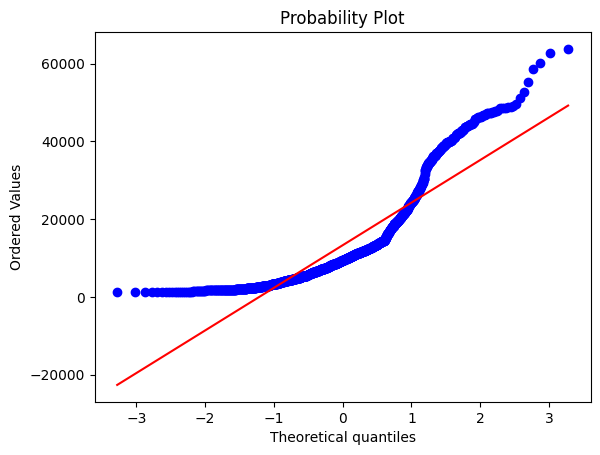

In [95]:
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

Normality is not fully met. The Omnibus and Jarque-Bera tests both have p-values below 0.05, indicating that the residuals are not normally distributed. Additionally, the normal probability plot shows some deviations from a straight line, further confirming this. This issue might arise because the BMI variable or its predictors contain non-normal data distributions.

Multicollinearity is mostly not a concern. The VIF values for predictors are all below 10, except for the constant, which is inherently high due to its definition. The condition number, however, is very large (1.15e+05), suggesting potential multicollinearity or numerical issues. This might result from highly correlated categorical predictors like regions or imbalanced data.

Autocorrelation is not present. The Durbin-Watson statistic is approximately 2, indicating no significant correlation between residuals. This is expected, as the dataset does not involve time-series data or sequential dependencies.

Linearity and homoscedasticity are not fully met. A pair plot shows the patterns or non-random spread between residuals and predictors, suggesting issues with linear relationships and equal variance. This could be due to unmeasured variables in the dataset, like distinct group behaviors in BMI across regions or smoker status.